<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [ ]:
# !nvidia-smi

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
%cd /content/segmentation-of-pelvic-bone/src

In [ ]:
!pip install SimpleITK

In [ ]:
!git pull

In [47]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [16]:
DATA_PATH = "/content/drive/My Drive/KTH/HL2027/data/"

## Load Data

In [50]:
X_train_3C = np.load(DATA_PATH + "train_X_3C.npy")
y_train = np.load(DATA_PATH + "train_y.npy")

X_train, X_val, y_train, y_val = train_test_split(X_train_3C, y_train, test_size=0.15, random_state=42, stratify=y_train)
print(f"X train shape:{X_train.shape}, y train shape:{y_train.shape} ")
print(f"X val shape:{X_val.shape}, y val shape:{y_val.shape} ")

X train shape:(729, 512, 512, 3), y train shape:(729,) 
X val shape:(129, 512, 512, 3), y val shape:(129,) 


## Inception V3 

In [51]:
input = tfkl.Input([None, None, 3], dtype = tf.int16)
x = tf.cast(input, tf.float32)
x = tfk.applications.inception_v3.preprocess_input(x)
inception_model = tfk.applications.InceptionV3(weights="imagenet", include_top=False, pooling="max")
inception_output = inception_model(x)
hidden_layer = tfkl.Dense(512, activation='relu')(inception_output)
hl_reg = tfkl.Dropout(0.2)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [52]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_5 (TFOpLambda)       (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0   

### Training 

In [54]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
inception_model.trainable = False
for layer in inception_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics=['acc'])

In [55]:
history = model.fit(x=X_train, y=y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
23/23 [==============================] - 11s 296ms/step - loss: 6.5795 - acc: 0.8025 - val_loss: 3.5140 - val_acc: 0.8837
Epoch 2/20
23/23 [==============================] - 3s 140ms/step - loss: 2.4945 - acc: 0.8368 - val_loss: 1.2861 - val_acc: 0.8837
Epoch 3/20
23/23 [==============================] - 3s 139ms/step - loss: 0.7790 - acc: 0.8793 - val_loss: 0.8379 - val_acc: 0.8837
Epoch 4/20
23/23 [==============================] - 3s 140ms/step - loss: 1.2211 - acc: 0.8615 - val_loss: 0.1147 - val_acc: 0.9612
Epoch 5/20
23/23 [==============================] - 3s 140ms/step - loss: 0.5195 - acc: 0.8985 - val_loss: 0.0727 - val_acc: 0.9767
Epoch 6/20
23/23 [==============================] - 3s 139ms/step - loss: 0.2307 - acc: 0.9163 - val_loss: 0.0590 - val_acc: 0.9612
Epoch 7/20
23/23 [==============================] - 3s 140ms/step - loss: 0.1823 - acc: 0.9273 - val_loss: 0.1046 - val_acc: 0.9535
Epoch 8/20
23/23 [==============================] - 3s 140ms/step - loss: 0

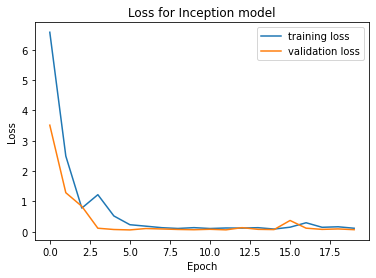

In [56]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title(f"Loss for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

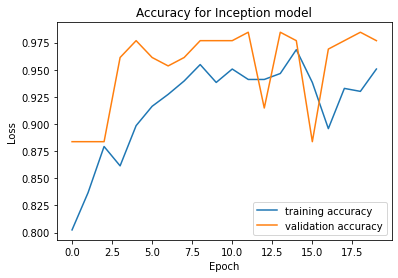

In [57]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title(f"Accuracy for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()